In [22]:
from constants import TRAIN_CNN_FLUXES_PATH, \
                      TRAIN_CNN_AMP_PHASE_PATH, \
                      VALIDATION_CNN_FLUXES_PATH, \
                      VALIDATION_CNN_AMP_PHASE_PATH

from data_utils import process_amp_phase_data, \
                       add_row_padding

from plot_utils import plot_map, \
                       plot_model_history, \
                       plot_autoencoder, \
                       plot_enc_conv_amp_phase_prediction


from modeling_utils import create_autoencoder_for_flux, \
                           create_convolutional_architecture_with_encoder_for_amplitude_phase_reconstruction, \
                           compile_model, \
                           train_model, \
                           store_model

from configurations import AutoEncoderConfiguration, \
                           EncoderConvolutionalConfiguration

In [23]:
fluxes_filename = "all_fluxes.npy"
amplitudes_filename = "complexsine_pupamp.npy"
phases_filename = "complexsine_pupphase.npy"

fluxes_path = f"{FLUXES_FOLDER}/{fluxes_filename}"
amplitudes_path = f"{SLM_FOLDER}/{amplitudes_filename}"
phases_path = f"{SLM_FOLDER}/{phases_filename}"

In [24]:
train_fluxes_array, val_fluxes_array, train_amp_phase_array, val_amp_phase_array, scalers = \
    process_amp_phase_data(
        n_points=30000,
        trim_amplitude=False,
        trim_phase=False,
        normalize_flux=True,
        normalize_amplitude=True,
        shuffle=False,
        flatten_fluxes=False,
        split=True,
        val_ratio=0.1,
        flux_top_padding=1,
        amp_phase_top_padding=8,
        amp_phase_bottom_padding=8
    )

FileNotFoundError: [Errno 2] No such file or directory: '../Data/plfluxes_simplepoly__pllabdata_20230625a_superK_slmcube_20230625_complsines-01sp_04//all_fluxes.npy'

In [4]:
model_configuration = AutoEncoderConfiguration(train_fluxes_array)
print(model_configuration.get_description())


	=== FluxAutoencoder ===
	*ARCHITECTURE HYPERPARAMETERS:
		-Autoencoder
		-Input shape: (56, 24)
		-Convolutional Layers: [512, 256, 64, 32] (Inverse in the decoder)
		-Convolutonal Kernels: [(3, 3), (3, 3), (3, 3), (3, 3)] (Inverse in the decoder)
		-Convolutional Activation: relu
		-Output Layer Activation: linear
	
	*COMPILATION HYPERPARAMETERS:
		-Optimizer: ADAM lr=0.0001, beta_1=0.9, beta_2=0.999
		-Loss Function: MSE
		-Metric: MSE
	
	* TRAINING HYPERPARAMETERS:
		-Epochs: 5
		-Batch size: 32
		-Callbacks:
			-ReduceLROnPlateau: MSE 8 x0.1
			-Early Stop: MSE 15
	


2023-12-11 12:51:13.691693: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-11 12:51:13.767795: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-11 12:51:13.768086: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
model = create_autoencoder_for_flux(
    *model_configuration.unpack_architecture_hyperparameters()
)


Model: "FluxAutoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 24, 512)       5120      
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 24, 512)       2359808   
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 12, 512)       0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 12, 256)       1179904   
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 12, 256)       590080    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 6, 256)        0         
 g2D)                                              

In [6]:
compile_model(
    model,
    *model_configuration.unpack_compilation_hyperparameters()
)

In [7]:
history = train_model(
    model,
    train_fluxes_array,
    train_fluxes_array,
    val_fluxes_array,
    val_fluxes_array,
    *model_configuration.unpack_training_hyperparameters()
)

Epoch 1/5


2023-12-11 12:51:15.412981: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-11 12:51:15.540226: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-11 12:51:16.564112: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-11 12:51:17.314539: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f187e842130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-11 12:51:17.314561: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2023-12-11 12:51:17.322975: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702259477.438763    4398 devic

844/844 [==============================] - 92s 97ms/step - loss: 0.0963 - mean_squared_error: 0.0963 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - lr: 1.0000e-04
Epoch 2/5
844/844 [==============================] - 76s 91ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - lr: 1.0000e-04
Epoch 3/5
844/844 [==============================] - 76s 91ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - lr: 1.0000e-04
Epoch 4/5
844/844 [==============================] - 77s 91ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - lr: 1.0000e-04
Epoch 5/5
844/844 [==============================] - 77s 91ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - lr: 1.0000e-04


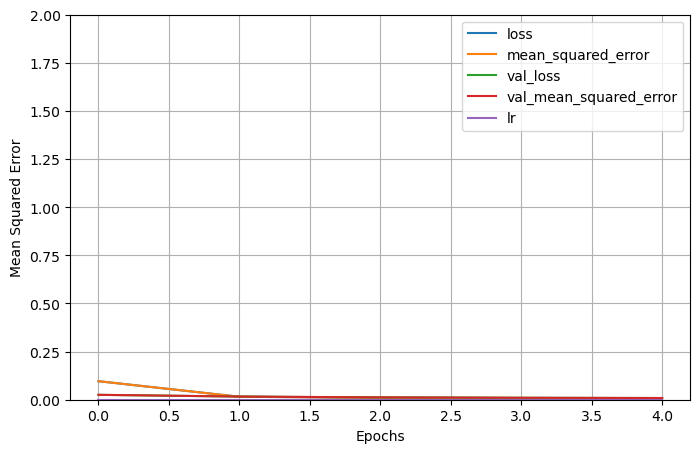

In [8]:
plot_model_history(history)

In [9]:
plot_autoencoder(model, val_fluxes_array[757])

1/1 [==============================] - 0s 336ms/step


1/1 [==============================] - 0s 13ms/step


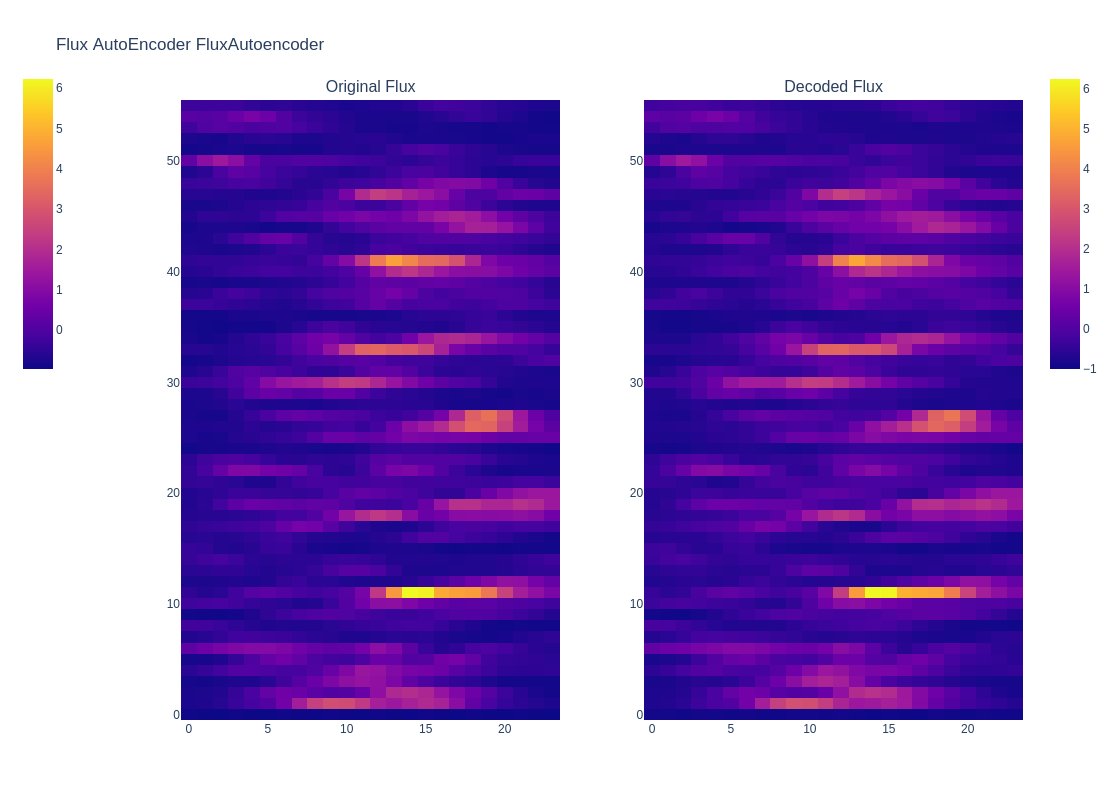

In [10]:
plot_autoencoder(model, val_fluxes_array[758])

In [11]:
store_model(model,
            model.name,
            model_configuration.get_description())

In [12]:
model_configuration = EncoderConvolutionalConfiguration()

In [13]:
enc_conv_model = create_convolutional_architecture_with_encoder_for_amplitude_phase_reconstruction(
    model,
    *model_configuration.unpack_architecture_hyperparameters())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 56, 24, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 56, 24, 512)       5120      
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 24, 512)       2359808   
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 12, 512)       0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 12, 256)       1179904   
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 12, 256)       590080    
                                                             

In [14]:
compile_model(
    enc_conv_model,
    *model_configuration.unpack_compilation_hyperparameters()
)

In [15]:
import numpy as np
train_amp_phase_array = np.swapaxes(train_amp_phase_array, 1, 3)
train_amp_phase_array = np.swapaxes(train_amp_phase_array, 1, 2)
val_amp_phase_array = np.swapaxes(val_amp_phase_array, 1, 3)
val_amp_phase_array = np.swapaxes(val_amp_phase_array, 1, 2)

In [16]:

history = train_model(
    enc_conv_model,
    train_fluxes_array,
    train_amp_phase_array,
    val_fluxes_array,
    val_amp_phase_array,
    *model_configuration.unpack_training_hyperparameters()
)

Epoch 1/20


2023-12-11 12:57:59.610189: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 693.32MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-11 12:57:59.610229: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 693.32MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-11 12:57:59.610243: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 693.32MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-11 12:57:59.610257: W external/local_tsl/tsl/framewor

844/844 [==============================] - 170s 183ms/step - loss: 0.4960 - mean_squared_error: 0.4960 - val_loss: 0.4237 - val_mean_squared_error: 0.4237 - lr: 1.0000e-04
Epoch 2/20
844/844 [==============================] - 140s 166ms/step - loss: 0.3973 - mean_squared_error: 0.3973 - val_loss: 0.4099 - val_mean_squared_error: 0.4099 - lr: 1.0000e-04
Epoch 3/20
844/844 [==============================] - 139s 165ms/step - loss: 0.3788 - mean_squared_error: 0.3788 - val_loss: 0.3724 - val_mean_squared_error: 0.3724 - lr: 1.0000e-04
Epoch 4/20
844/844 [==============================] - 139s 165ms/step - loss: 0.3662 - mean_squared_error: 0.3662 - val_loss: 0.3729 - val_mean_squared_error: 0.3729 - lr: 1.0000e-04
Epoch 5/20
844/844 [==============================] - 139s 165ms/step - loss: 0.3567 - mean_squared_error: 0.3567 - val_loss: 0.3729 - val_mean_squared_error: 0.3729 - lr: 1.0000e-04
Epoch 6/20
844/844 [==============================] - 139s 165ms/step - loss: 0.3503 - mean_squa

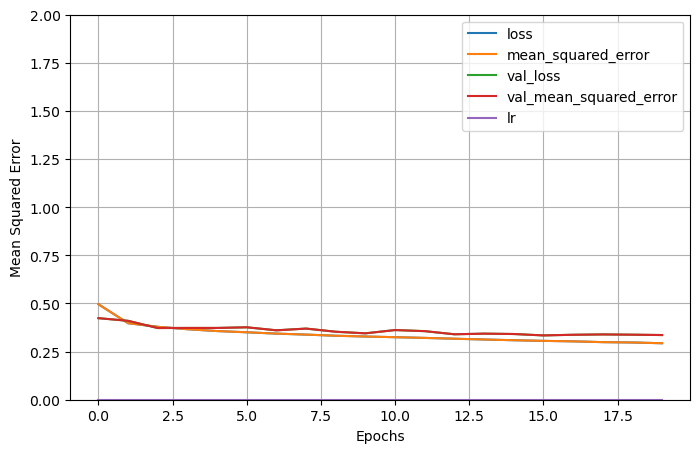

In [21]:
plot_model_history(history)

In [17]:
train_amp_phase_array = np.swapaxes(train_amp_phase_array, 2, 1)
train_amp_phase_array = np.swapaxes(train_amp_phase_array, 3, 1)
val_amp_phase_array = np.swapaxes(val_amp_phase_array, 2, 1)
val_amp_phase_array = np.swapaxes(val_amp_phase_array, 3, 1)

In [18]:
plot_enc_conv_amp_phase_prediction(enc_conv_model,
                                   train_fluxes_array[0], 
                                   train_amp_phase_array[0][0],
                                   train_amp_phase_array[0][1])

1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 13ms/step


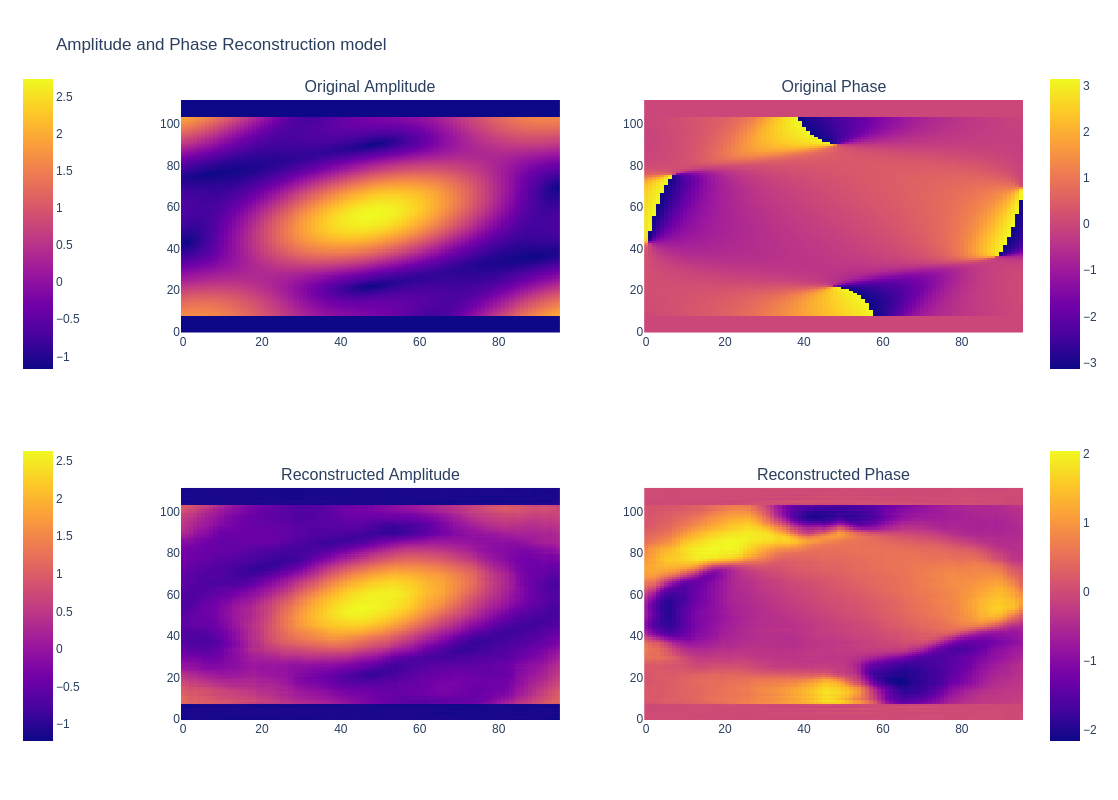

In [19]:
plot_enc_conv_amp_phase_prediction(enc_conv_model,
                                   val_fluxes_array[0], 
                                   val_amp_phase_array[0][0],
                                   val_amp_phase_array[0][1])